# Прогнозирование цен на жилье с помощью байесовских методов

##### Задача :
Используя фреймворк байесовских методов и библиотеку PyMC3 необходимо построить интерпретируемую вероятностную модель и решить задачу регрессии по прогнозированию стоимости жилья в г.Эймс. Исходные данные с ценами на жилье на (https://www.kaggle.com/c/house-prices-advanced-regression-techniques>) 

In [1]:

import pandas as pd
import numpy as np
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
from scipy.integrate import odeint
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error,r2_score

warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

# Отключение предупреждений
warnings.filterwarnings('ignore')

# Определение максимального количества колонок в таблице
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on ArviZ v{az.__version__}")
print(f"Running on Pymc3 v{pm.__version__}")


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on ArviZ v0.11.4
Running on Pymc3 v3.11.5


In [172]:
# helper functions
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):

    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)

    # Linear Model that estimates a grade based on the value of the query variable
    # and one sample from the trace
    def lm(value, sample):

        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value

        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:

            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()

        return prediction

    plt.figure(figsize=(6, 6))

    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()

    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100),
                                     lm=lm, samples=100, color='blue',
                                     alpha=0.4, lw=2)

    # Plot formatting
    plt.xlabel('%s' % query_var, size=16)
    plt.ylabel('SalePrice', size=16)
    plt.title("Posterior of SalePrice vs %s" % query_var, size=18)
    plt.show()


def evaluate_trace(trace, X_train, X_test, y_train, y_test):

    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    var_weights = pd.DataFrame(var_dict)
    var_means = var_weights.mean(axis=0)
    X_test['Intercept'] = 1
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]

    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index=X_test.index, columns=['estimate'])
    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(
            np.array(var_means), np.array(row[1]))

    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))

    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    model_results = (mae, rmse)

    return model_results, results

### Загрузка данных

In [2]:
data = pd.read_csv('data/housing.csv',index_col=['Id'])
data.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### EDA

In [3]:
print("Размерность данных: ",data.shape)
data.info()

Размерность данных:  (1460, 80)
<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-n

### Преобразование колонок
В нескольких случаях данные ошибочно имеют тип 'float' хотя выражают оценку 


In [4]:

data["OverallQual"] = data["OverallQual"].astype(object)
data["OverallCond"] = data["OverallCond"].astype(object)
data["MSSubClass"] = data["MSSubClass"].astype(object)
# преобразуем в float
data["LotArea"] = data["LotArea"].astype(float)
data["BsmtFinSF1"] = data["BsmtFinSF1"].astype(float)
data["BsmtFinSF2"] = data["BsmtFinSF2"].astype(float)
data["BsmtUnfSF"] = data["BsmtUnfSF"].astype(float)
data['TotalBsmtSF'] = data['TotalBsmtSF'].astype(float)
data['1stFlrSF'] = data['1stFlrSF'].astype(float)
data['2ndFlrSF'] = data['2ndFlrSF'].astype(float)
data['LowQualFinSF'] = data['LowQualFinSF'].astype(float)
data['GrLivArea'] = data['GrLivArea'].astype(float)
data['WoodDeckSF'] = data['WoodDeckSF'].astype(float)
data['OpenPorchSF'] = data['OpenPorchSF'].astype(float)
data['SalePrice'] = data['SalePrice'].astype(float)
data['PoolArea'] = data['PoolArea'].astype(float)
data['ScreenPorch'] = data['ScreenPorch'].astype(float)
data['GarageArea'] = data['GarageArea'].astype(float)
data['3SsnPorch'] = data['3SsnPorch'].astype(float)

In [41]:
# удаляем колонки с freq>1400 так как большинство значений одинаковые
col_freq = data.describe(include=[object]).T['freq']
low_freq_col = col_freq.loc[col_freq > 1400].index.to_list()
low_freq_col

data.drop(columns=low_freq_col, inplace=True)

In [5]:
print('Дубликатов -', data.duplicated().sum())
print('Пропущенных значений %-')
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()
           ).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=[
                         'Total Missing', 'Percent Missing'])
missing_data.head(20)

Дубликатов - 0
Пропущенных значений %-


,Total Missing,Percent Missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


In [9]:
# удалим колонки в которых есть пропущенные значения
data = data.drop(
    (missing_data[missing_data['Total Missing'] > 0]).index, axis=1)

### Корреляция числовых значений

<Axes: >

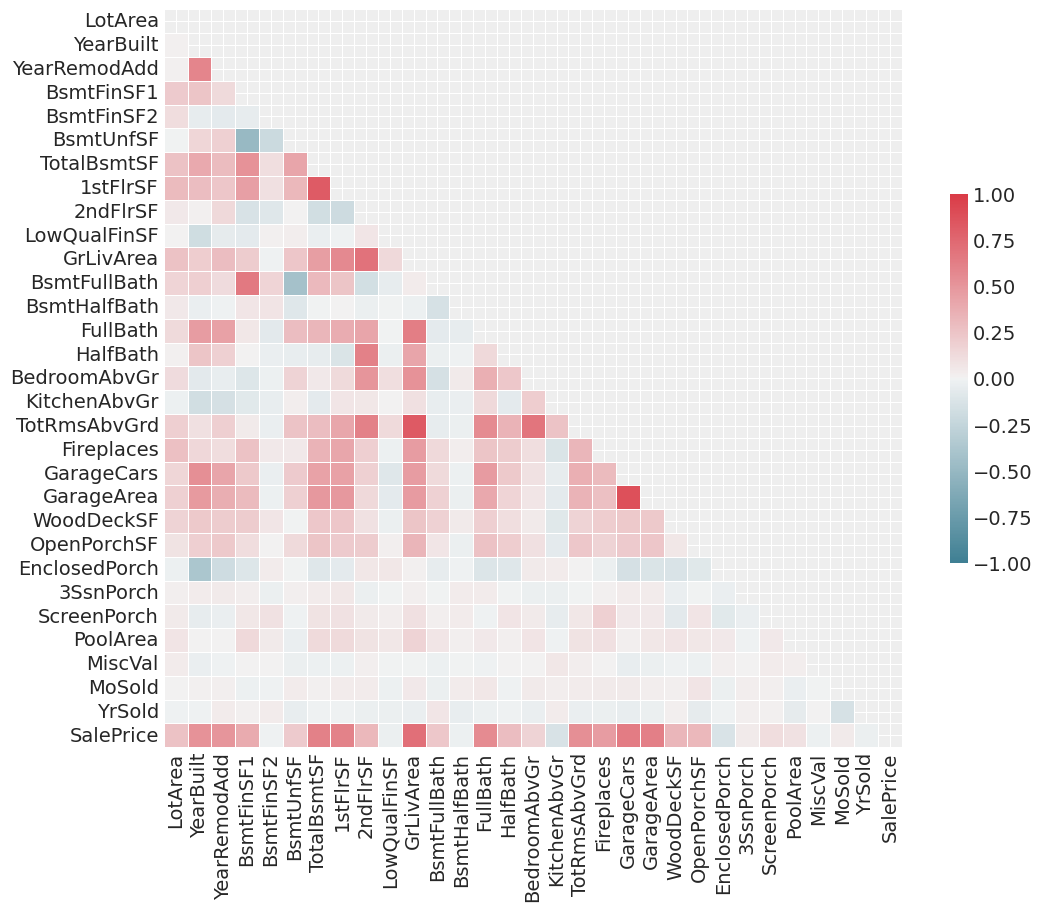

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_mat = data.select_dtypes(['float', 'int']).corr()
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True, center="light")
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
# Удаляем значения которые коррелируют с целевой переменной менее чем на 20%
data = data.drop(
    columns=corr_mat["SalePrice"].loc[corr_mat["SalePrice"].abs() < 0.2].index)

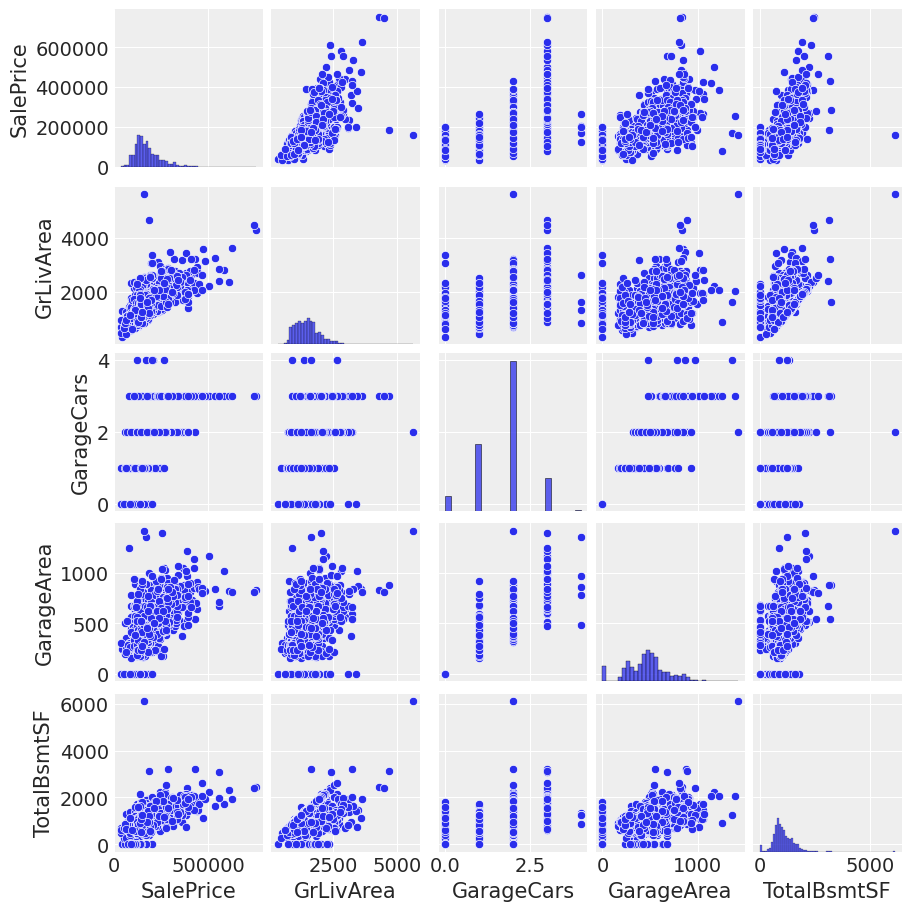

In [19]:
# Парный график 5 параметров с самой высокой корреляцией
cols = corr_mat["SalePrice"].sort_values(ascending=False).index.tolist()[0:5]
sns.pairplot(data[cols], height=1.8)
plt.show()

На графике ниже 2 точки очень сильно выделяются , будем считать их выбросами и удалим их

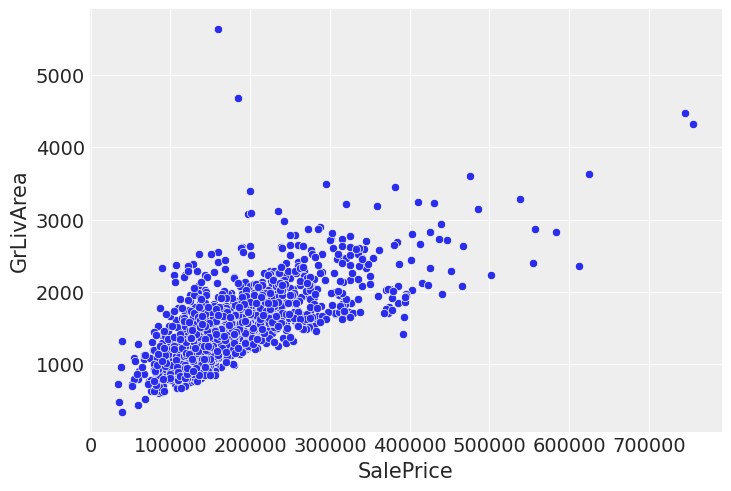

In [20]:

sns.scatterplot(data=data, x='SalePrice', y='GrLivArea')

plt.show()

In [21]:
# удаление выбросов
outlets = data.loc[(data['SalePrice'] < 300000) &
                   (data['GrLivArea'] > 4000)].index
print(f'определим две точки {outlets.values} как выбросы и удалим из данных')
data.drop(outlets, inplace=True)

определим две точки [ 524 1299] как выбросы и удалим из данных


### Базовая модель Random Forest

Строим базовую частотную модель

In [25]:

# Определяем целевую переменную SalePrice
y = data['SalePrice'].copy()
data_x = data.drop(columns=['SalePrice'])


categorical_features = data_x.columns[data_x.dtypes == object].to_list()
numerical_features = [
    col for col in data_x.columns if col not in categorical_features]

X = data_x[numerical_features+categorical_features].copy()

# кодируем категориальные переменные
X[categorical_features] = X[categorical_features].apply(
    LabelEncoder().fit_transform)

# делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


# Создание пайплайна
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numerical_features),
    ],
    remainder='passthrough'
)

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_select', VarianceThreshold(0.02)),
    ('model', RandomForestRegressor())])

pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'FullBath', 'HalfBath',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageCars', 'GarageArea',
                                                   'WoodDeckSF',
                                                   'OpenPorchSF'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('var_select', VarianceThreshold(threshold=0.02)),
                ('model', RandomForestRegressor())])

In [170]:
# Оценка модели

pred_rf = pipeline_rf.predict(X_test)

mse_rf = mean_absolute_error(y_test.values, pred_rf)
r2score_rf = r2_score(y_test.values, pred_rf)
print(f'Mean Absolute Error Random Forest (base): {mse_rf:.2f}')
print('------------------------------------------------')
print(f'R2 Score Random Forest (base): {r2score_rf:.2f}')

Mean Absolute Error Random Forest (base): 16930.96
------------------------------------------------
R2 Score Random Forest (base): 0.89


Text(0.5, 1.0, 'Наблюдаемые и предсказанные значения')

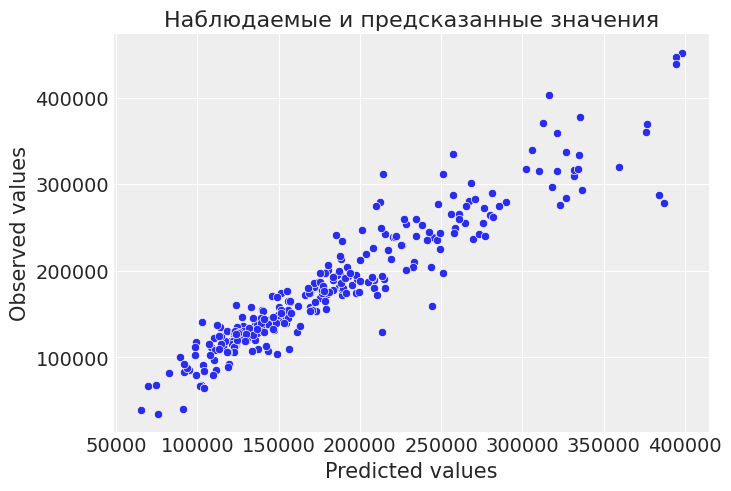

In [171]:
sns.scatterplot(x=pred_rf, y=y_test.values)
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.title('Наблюдаемые и предсказанные значения')

## Вероятностная модель

Для построения вероятностной модели возьмем 2 наиболее коррелируемый с целевой переменной параметра

In [46]:
# GrLivArea
X1 = X_train['GrLivArea'].values
# TotalBsmtSF
X2 = X_train['TotalBsmtSF'].values

In [95]:
with pm.Model() as model:

    Intercept = pm.Normal("Intercept", mu=0.8, sigma=0.75)
    GrLivArea = pm.Normal("GrLivArea", mu=25, sigma=5)
    TotalBsmtSF = pm.Normal("TotalBsmtSF", mu=120, sigma=5)
    sd = pm.HalfNormal("sd", sigma=5000)

    mu = Intercept + GrLivArea*X1 + TotalBsmtSF*X2

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sd, observed=y_train)

    map_estimate = pm.find_MAP()
    print(map_estimate)


{'Intercept': array(0.79976265), 'GrLivArea': array(59.10302575), 'TotalBsmtSF': array(90.17538867), 'sd_log__': array(10.72390168), 'sd': array(45428.80611772)}


In [96]:
#Постериорные образцы
with model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, TotalBsmtSF, GrLivArea, Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


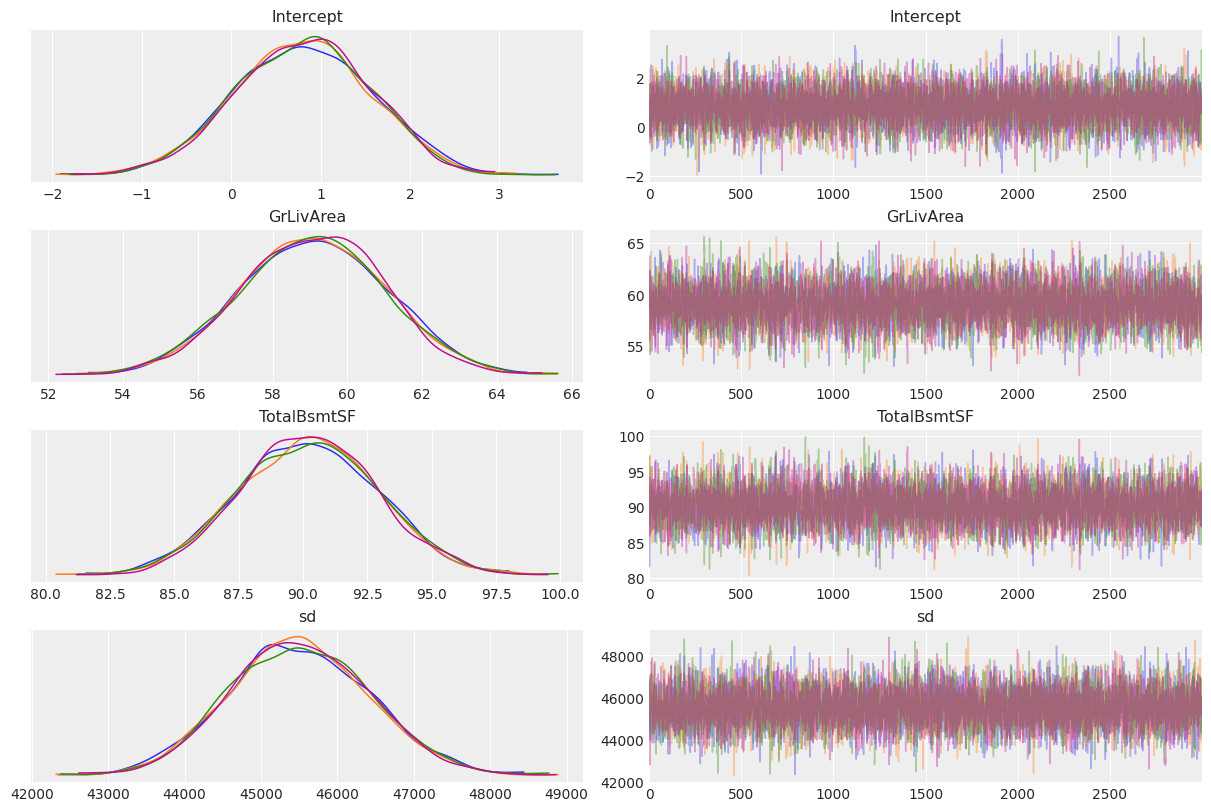

In [97]:
with model:
    az.plot_trace(trace, compact=False, combined=False)
    

In [98]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.80,0.76,-0.61,2.19,0.01,0.01,10368.04,7725.16,1.0
GrLivArea,59.08,1.94,55.63,62.90,0.02,0.02,6781.19,7009.89,1.0
TotalBsmtSF,90.20,2.68,85.20,95.23,0.03,0.02,6790.33,7574.04,1.0
sd,45504.14,912.02,43840.43,47251.70,9.18,6.49,9858.78,7719.05,1.0


In [99]:
count = trace.get_values('Intercept').shape[0]
with model:
    y_pred = pm.sample_posterior_predictive(trace, samples=count, model=model)
    data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred)

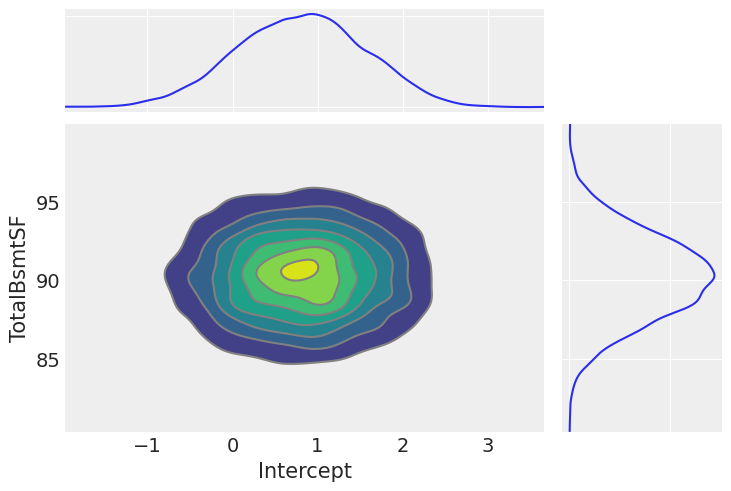

In [100]:
with model:
    joint_plt = az.plot_joint(
        data_spp, var_names=['Intercept', 'TotalBsmtSF'], kind='kde', fill_last=False)

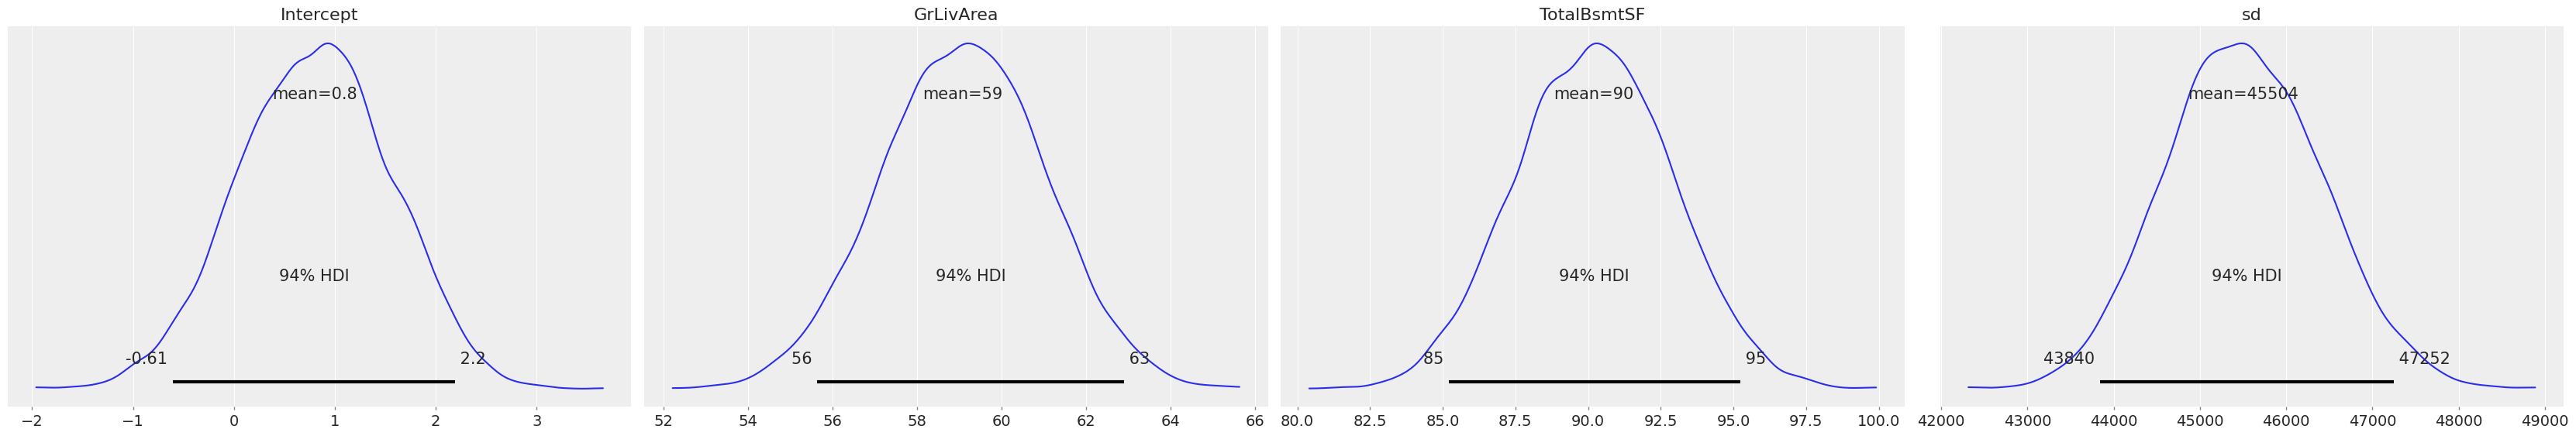

In [162]:
with model:
    pm.plot_posterior(trace)

## Оценка влияния переменных

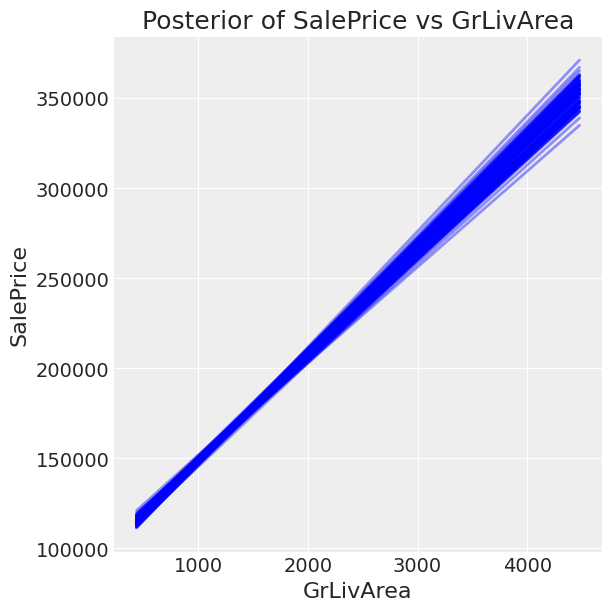

In [168]:
model_effect('GrLivArea',trace,X_train[['GrLivArea','TotalBsmtSF']])

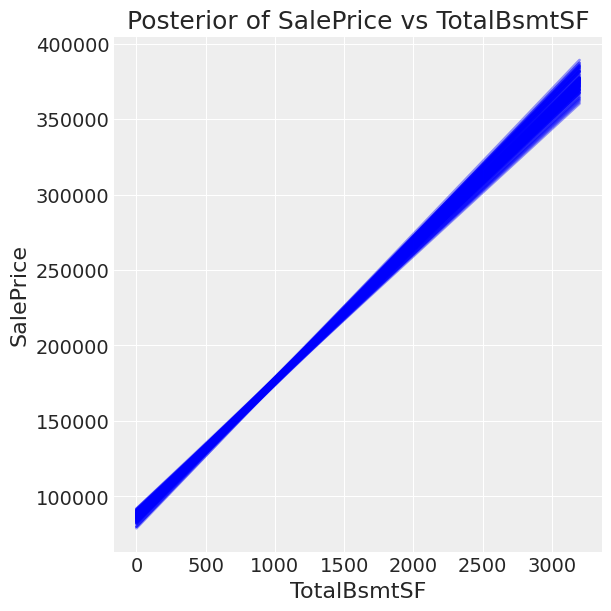

In [169]:
model_effect('TotalBsmtSF',trace,X_train[['GrLivArea','TotalBsmtSF']])

## Оценка модели обученной по 2м переменным

In [157]:
model_result, predict = evaluate_trace(trace, X_train[['GrLivArea', 'TotalBsmtSF']], X_test[[
                                       'GrLivArea', 'TotalBsmtSF']], y_train, y_test)

Model  MAE: 86867.7561
Model RMSE: 103703.8621


Text(0.5, 1.0, 'Наблюдаемые и предсказанные значения')

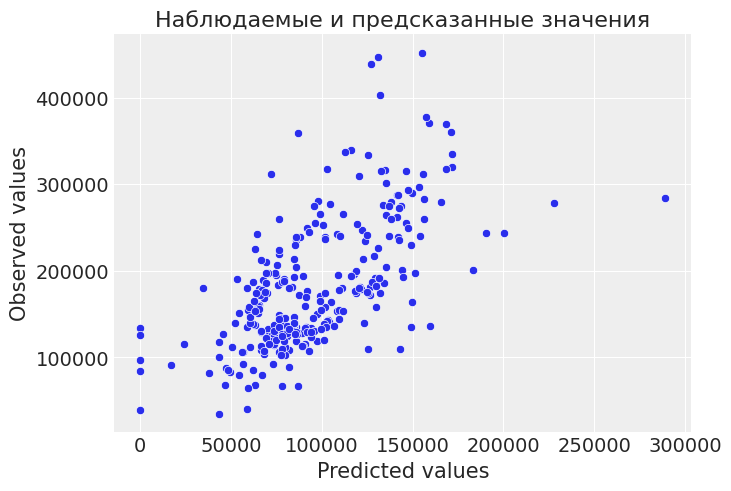

In [174]:
sns.scatterplot(x=predict['estimate'].values, y=y_test.values)
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.title('Наблюдаемые и предсказанные значения')

В целом модель получилась хуже модели RandomForest , но это связано с тем что модель обучалась только на 2 переменных